# Lab 7: Vector data in xarray

The goals of this lab are to show how to visualize multi-dimensional vector data (with arrows and streamlines, slicing along levels), and to combine datasets to address broad science questions. 

Our science questions are:
- Where is average wind speed the highest?
    - Are winds stronger over land or ocean?
    - Is wind strongest lower or higher in the atmosphere?
- Where is vertical motion in the atmosphere the strongest?
- What drives strong winds?

## Science background
Wind is a *vector* quantity.  It has both magnitude and direction.  We can express a vector in terms of its *components*. We typically use $u$ for the component of wind pointing in the $x$-direction, and $v$ for the component pointing in the $y$-direction.

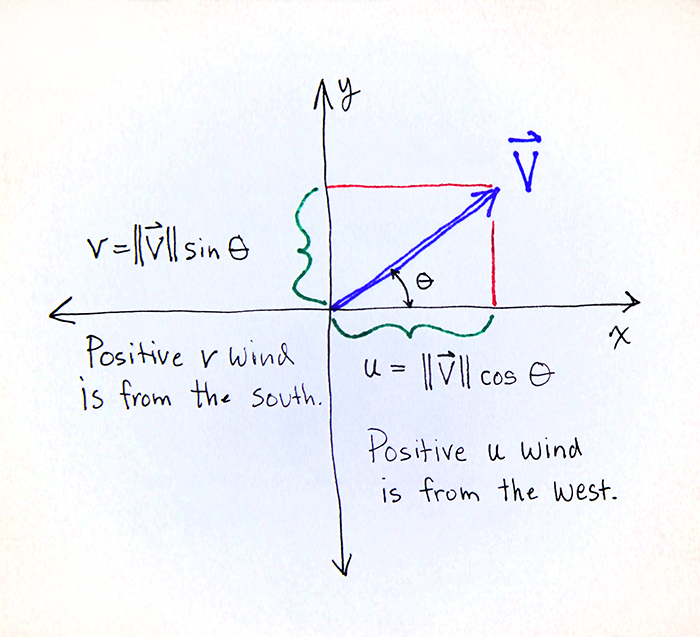

Image credit: [George Mason University](http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv).

---
## Part 1: Demonstration and skills practice

In [ ]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## Data sources 

We are going to use the `ERA5_LowRes_MonthlyAvg_uvslp.nc` and `ERA5_LowRes_MonthlyAvg_4D_zuvw.nc` files that you can download from:
- [ERA5_LowRes_MonthlyAvg_uvslp.nc](https://cluster.klima.uni-bremen.de/~fmaussion/teaching/climate/ERA5_LowRes_MonthlyAvg_uvslp.nc)
- [ERA5_LowRes_MonthlyAvg_4D_zuvw.nc](https://cluster.klima.uni-bremen.de/~fmaussion/teaching/climate/ERA5_LowRes_MonthlyAvg_4D_zuvw.nc)

## Read the data

In [ ]:
ds = xr.open_dataset('./data/ERA5_LowRes_MonthlyAvg_uvslp.nc')

In [ ]:
ds

### 1. Plotting vector fields

Let's read the $u$ and $v$ wind fields at the 10 m level for the month of January.

In [ ]:
u = ds.u10.sel(month=1).load()
v = ds.v10.sel(month=1).load()

#### Quiver plots

Vectors are often plotted as arrows, to show their direction.  We can use a matplotlib built-in function called [quiver()](http://matplotlib.org/api/pyplot_api.html?highlight=quiver#matplotlib.pyplot.quiver) to plot the wind data:

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())  # note that I changed the map projection
pu, pv = u[::9,::9], v[::9,::9]  # we will discuss what this line does in the cells below
qv = ax.quiver(pu.longitude, pu.latitude, pu, pv, transform=ccrs.PlateCarree()) ## matplotlib command, not xarray
ax.coastlines(color='grey');

Note the slicing in the line `pu, pv = u[::9,::9], v[::9,::9]`. You can return to Lab 1 for a general review of slicing as needed.  

Here we have sliced both `u` and `v` (two-dimensional) and assigned them to `pu` and `pv`. You'll notice we can use a comma to accomplish both in the same line -- much like when we used a comma to return or assign multiple outputs from a function.  This is a style choice and could also be done in multiple lines.  **Tip: only use the single-line comma-separated assignment style when the things you are computing are related.**

**Discuss: what are `pu` and `pv`?  Why do we need them?**

*...your notes here...*

In [ ]:
## live code: attempt to plot `pu` and `pv` with numbers other than 9.  What happens?


The slicing changes the density of arrows plotted.

#### *Exercise*:
Compute the wind speed from `u` and `v`. Plot the wind speed as a shaded map view and plot the wind arrows on top of it.

*Hint*: Pythagorean theorem!

In [ ]:
## your code here

#### Streamplots

Another way to plot wind data is called [streamlines](http://matplotlib.org/api/pyplot_api.html?highlight=streamplot#matplotlib.pyplot.streamplot):

In [ ]:
ax = plt.axes(projection=ccrs.EqualEarth())
ax.streamplot(u.longitude, u.latitude, u.values, v.values, transform=ccrs.PlateCarree(), density=4)
ax.coastlines(color='grey');

*Note: if this is too slow for your taste, you can slice your data like we did for the quiver plot, which will produce the plot faster*

A problem with streamlines is that they provide no information about the strength of the flow. It is possible to display this information with colors: 

In [ ]:
ws = (u**2 + v**2)**0.5 ## compute and save the values to use
ax = plt.axes(projection=ccrs.EqualEarth())
strm = ax.streamplot(u.longitude, u.latitude, u.values, v.values, transform=ccrs.PlateCarree(),
                     density=4, color=ws.values, cmap=plt.get_cmap('cool'))
plt.colorbar(strm.lines)
ax.coastlines(color='grey'); ax.gridlines(draw_labels=True);  # what is this line doing?

#### *Exercise*:
Plot the wind streamlines for the month of July. Identify and describe key differences between January (already plotted) and July. Where it the ITCZ located for both months?

In [ ]:
## your code here

---
### 2. Four-dimensional data?!

Some climate data have many (many) dimensions.  Here we will add just one more for a total of four: latitude, longitude, month, and *vertical level*. 

We are now going to use the `ERA-Int-MonthlyAvg-4D-UVWZ.nc` file:

In [ ]:
ds2 = xr.open_dataset('./data/ERA5_LowRes_MonthlyAvg_4D_zuvw.nc')
ds2

In [ ]:
ds2.level

In [ ]:
u_allz = ds2.u.sel(month=1).load()
u_allz = u_allz.mean(dim='longitude')

In [ ]:
u_allz.plot();

Ugh. Stripes and boxes! With `contourf` we can make it a bit better.  Note that this plotting function exists in both matplotlib and xarray; below we use matplotlib to control the axes but plot with the xarray version of `contourf`.

In [ ]:
fig, ax = plt.subplots()
u_allz.plot.contourf(levels=np.linspace(-45, 45, 19), cbar_kwargs={'label':'U-wind (m s-1)'}, ax=ax);
ax.set(ylim=[1000, 50],
       ylabel='Pressure (hPa)');

This representation of the atmosphere (with linear pressure coordinates) is okay for a first look. But a logarithmic scale gives more accurate representation of pressure with altitude:

In [ ]:
fig, ax = plt.subplots()
u_allz.plot.contourf(levels=np.linspace(-45, 45, 19), cbar_kwargs={'label':'U-wind (m s-1)'}, ax=ax);
# u_allz.plot();
ax.set(ylim=[1000, 50],
            yscale='log', ## set a logarithmic y-scale
            ylabel='Pressure (hPa)')

#### *Exercise*:

Compute the annual average of the vertical component of the wind. Select and plot the **500 hPa level** on a map.  Adjust the plot to show the data most effectively.

In [ ]:
## your code here

Note and discuss the features of the plot. Order of magnitude of w in comparison to u and v? Where are the largest velocities? Look at the sign of w in the tropics and the subtropics. Does it make sense?

---
## Part 2: Lab procedure

Address the science questions above by building on the skills you've developed this week and previously.  

Your approach should take the following general steps:
1. Plot the mean sea level pressure on a map and add an appropriate visual representation of wind vectors over it.  Describe any noticeable features when these data are overlaid.
2. Compare the plot of sea level pressure to a plot of vertical wind speed (w) on the same map projection.  Describe any relationship between pressure and vertical motion in the atmosphere.
3. Make a vertical profile of maximum wind speed -- x-axis mean wind speed, y-axis pressure level in the atmosphere.  Identify the relationship between wind speed and altitude in the atmosphere.
4. Compute a surface wind speed field and mask it for values over the ocean and land.  Find the mean and maximum of each masked field.  Describe what you find and offer a possible explanation.
5. Identify the maximum horizontal (u,v) wind speed and mark it on the map.  *Hint: see footnotes for a method.*
6. Based on the patterns you have identified, describe what factors appear to drive strong wind speeds.

Don't forget to include code comments and markdown cells *explaining and interpreting what you are doing*!

In [ ]:
## add cells of code and markdown here to complete the procedure

---
## Endnotes
- This notebook is based on material from Fabien Maussion's [Physics of the Climate System notebooks](https://fabienmaussion.info/climate_system/week_04/01_Lesson_Wind-Derivatives-Integrals.html).
- Last update: 2 Apr 2024, Lizz Ultee
- I had to look up the xarray equivalent of argmax!  See [this StackOverflow post](https://stackoverflow.com/questions/40179593/how-to-get-the-coordinates-of-the-maximum-in-xarray).  If you have a DataArray called `da`, you can find the max value and its coordinates using:
`da.where(da==da.max(), drop=True).squeeze()`